In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
import joblib

In [3]:
import sklearn

In [4]:
from sklearn.tree import plot_tree

In [5]:
from sklearn.ensemble import RandomForestClassifier

In [6]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split, ShuffleSplit

In [7]:
from sklearn.metrics import roc_curve, plot_roc_curve, RocCurveDisplay, auc

In [8]:
sns.set_theme(style="ticks")

In [9]:
import random

In [10]:
import utils

In [11]:
import gc

In [12]:
X_dtypes = utils.get_X_dtypes()

In [13]:
def adjust_X(X_):
    X_["ct_epoch"] = X_["ct_block_height"] // 1008
    X_ = X_.drop(columns=["ct_fee", "co_output_value", "ct_block_height", "co_is_larger_output", "co_fresh_output", "co_other_fresh"])
    CATEGORICAL_COLUMNS = [x for x in X_.columns if x[:3] != "ct_" and x[:3] != "co_"]
    X_[CATEGORICAL_COLUMNS] = X_[CATEGORICAL_COLUMNS].replace([0, -1], [-1, 0])
    
    return X_

### Load classifiers

In [14]:
X_cols = joblib.load(utils.get_base_path('model/X_columns_full.pkl'))

In [15]:
rfc_full = joblib.load(utils.get_base_path("model/rfc-full.pkl"))

In [16]:
X_nofp_cols = joblib.load(utils.get_base_path('model/X_columns_nofp.pkl'))

In [17]:
rfc_nofp = joblib.load(utils.get_base_path("model/rfc-nofp.pkl"))

In [18]:
X_dtypes = utils.get_X_dtypes()

In [19]:
FINGERPRINT_COLS = [x for x in X_cols if x[:3] == "fp_"]

In [20]:
NON_HEURISTICS = [x for x in X_cols if x[:3] == "ct_" or x[:3] == "co_"]

## Ransomware

In [57]:
ransom_gt = pd.read_csv(utils.get_base_path("model-validation/20210720-ransomware-gt.csv"), index_col=0, dtype=X_dtypes)

In [58]:
len(ransom_gt)

22392

In [59]:
all_outs_spent = ransom_gt["all_outputs_spent"].values

In [60]:
ransom_X = ransom_gt.drop(columns=["true_change", "all_outputs_spent"])

In [61]:
ransom_X = adjust_X(ransom_X)

In [62]:
ransom_X_spent = ransom_X[all_outs_spent].copy()

In [63]:
ransom_X_unspent = ransom_X[~all_outs_spent].copy()

In [64]:
ransom_y = ransom_gt["true_change"]

In [65]:
ransom_y_spent = ransom_y[all_outs_spent].copy()
ransom_y_unspent = ransom_y[~all_outs_spent].copy()

In [66]:
FINGERPRINT_COLS = [x for x in X_cols if x[:3] == "fp_"]

In [67]:
ransom_X_unspent = ransom_X_unspent.drop(columns=FINGERPRINT_COLS)

In [68]:
assert len(X_cols) == len(ransom_X_spent.columns)
assert len(X_nofp_cols) == len(ransom_X_unspent.columns)

In [69]:
ransom_X_spent = ransom_X_spent[X_cols]
ransom_X_unspent = ransom_X_unspent[X_nofp_cols]

In [70]:
assert (X_cols == ransom_X_spent.columns).all()
assert (X_nofp_cols == ransom_X_unspent.columns).all()

In [71]:
ransom_y_proba_spent = rfc_full.predict_proba(ransom_X_spent)[:, 1]

In [72]:
ransom_y_proba_unspent = rfc_nofp.predict_proba(ransom_X_unspent)[:, 1]

In [73]:
ransom_y_proba_combined = np.concatenate([ransom_y_proba_spent, ransom_y_proba_unspent])

In [74]:
ransom_y_combined = np.concatenate([ransom_y_spent, ransom_y_unspent])

In [75]:
fpr_, tpr_, tr_ = roc_curve(ransom_y_combined, ransom_y_proba_combined)

In [76]:
roc_auc_ = auc(fpr_, tpr_)

In [77]:
roc_auc_

0.9964282248572675

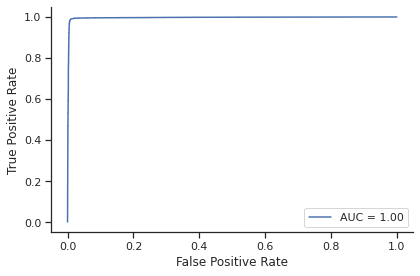

In [78]:
ax = RocCurveDisplay(fpr=fpr_, tpr=tpr_, roc_auc=roc_auc_).plot()
sns.despine()
plt.tight_layout()

## Cluster interaction (EXTENDED)

In [79]:
ci_gt = pd.read_csv(utils.get_base_path("model-validation/20210720-cluster-interaction-extensive-gt.csv"), index_col=0, dtype=X_dtypes)

In [80]:
len(ci_gt)

537548

In [81]:
all_outs_spent = ci_gt["all_outputs_spent"].values

In [82]:
ci_X = ci_gt.drop(columns=["true_change", "all_outputs_spent"])

In [83]:
ci_X = adjust_X(ci_X)

In [84]:
ci_X_spent = ci_X[all_outs_spent].copy()

In [85]:
ci_X_unspent = ci_X[~all_outs_spent].copy()

In [86]:
ci_y = ci_gt["true_change"]

In [87]:
ci_y_spent = ci_y[all_outs_spent].copy()
ci_y_unspent = ci_y[~all_outs_spent].copy()

In [88]:
ci_X_unspent = ci_X_unspent.drop(columns=FINGERPRINT_COLS)

In [89]:
assert len(X_cols) == len(ci_X_spent.columns)
assert len(X_nofp_cols) == len(ci_X_unspent.columns)

In [90]:
ci_X_spent = ci_X_spent[X_cols]
ci_X_unspent = ci_X_unspent[X_nofp_cols]

In [91]:
assert (X_cols == ci_X_spent.columns).all()
assert (X_nofp_cols == ci_X_unspent.columns).all()

In [92]:
ci_y_proba_spent = rfc_full.predict_proba(ci_X_spent)[:, 1]

In [93]:
ci_y_proba_unspent = rfc_nofp.predict_proba(ci_X_unspent)[:, 1]

In [94]:
ci_y_proba_combined = np.concatenate([ci_y_proba_spent, ci_y_proba_unspent])

In [95]:
len(ci_y_proba_combined)

537548

In [96]:
ci_y_combined = np.concatenate([ci_y_spent, ci_y_unspent])

In [97]:
fpr_, tpr_, tr_ = roc_curve(ci_y_combined, ci_y_proba_combined)

In [98]:
roc_auc_ = auc(fpr_, tpr_)

In [99]:
roc_auc_

0.9757453558776226

In [101]:
tprint = [0.1, 0.05, 0.04, 0.03, 0.02, 0.01, 0.005, 0.001, 0.0007, 0.0006, 0.0005, 0.0001]
pf, pt, ptr = fpr_[0], tpr_[0], tr_[0]
next_threshold = tprint.pop()
for f, t, tr in zip(fpr_, tpr_, tr_):
    if f == pf:
        pf, pt, ptr = f, t, tr
    else:
        if f > next_threshold:
            print(pf, pt, ptr)
            if not tprint:
                break
            next_threshold = tprint.pop()
        pf, pt, ptr = f, t, tr


0.0 0.0 2.0
0.0005060013245328789 0.06930357847113187 0.9999994540888743
0.0005990162738955405 0.14768541600005952 0.9996371705691939
0.000699472419207215 0.18351849509253126 0.9992583227981459
0.000997120257167732 0.3086310431812601 0.9969319087245292
0.004996763079762179 0.6381048762157054 0.9536802004266407
0.009997246757498865 0.7050644779628982 0.9201657787246618
0.019998214112972236 0.778349096266752 0.8535762496163088
0.029995460870471103 0.820611368659171 0.7907662077043178
0.03999642822594447 0.8456509930275994 0.7330879540198205
0.049993674983443336 0.8639377320722986 0.683613182721086
0.09999851176081019 0.9253982900131709 0.4415426934893349
